# Compare methods with optimize parameters in ref_case

In [10]:
import xarray as xr
import pandas as pd
import numpy as np

import hvplot.xarray
import hvplot.pandas

import matplotlib.pyplot as plt
from cycler import cycler

from sstats import signals as sg
from sstats import sigp as sigp
from sstats import tseries as ts
from sstats import get_cmap_colors

import hvplot.xarray
import hvplot.pandas
import holoviews as hv

import pynsitu as pyn

from lib import KEYS, raw_dir, images_dir

import os
from glob import glob

import synthetic_traj as st

from synthetic_traj import (
    synthetic_traj,
    noise_irregular_sampling,
    ref_case,
    typical_case,
    random_time_begin,
    dataset2dataframe_drop
)
import lib

___________
# Reference case + carthe_lops 5min

In [6]:
N = 100
acc_cut = 1e-3
position_noise = 20
ntype = "white_noise"
offset_type = "carthe_lops_5"
dt_smooth = "30min"
true_key = "True_" + dt_smooth
spectral_diff = False
ref_case["spectral_diff"] = spectral_diff
print(ref_case)

dt_rd_begin = 5*60

param_lowess = dict(degree=2, iteration=3, T_low_pass = 1, nb=4, cutoff_low_pass = 11.5)

{'T': 5, 'U_low': 0.3, 'U_ni': 0.2, 'U_2': 0, 'U_1': 0, 'tau_eta': 0.1, 'n_layers': 5, 'spectral_diff': False}


___________
# DST, DSO_
dst = 1min, ref_case  

dso_ istart 4067, random initialisation

In [4]:
# IF ALREADY SAVED
DF = dict()
from lib import doc_dir
dst = xr.open_dataset(doc_dir + '/dst.nc')
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

dso_ = xr.open_dataset(doc_dir + '/dso_.nc')
dfo = st.dataset2dataframe_drop(dso_).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")
DF["Observed"] = dfo

In [9]:
#COMPUTE
DF = dict()

# TRUE
t = (
    50,
    "1min",
)  # use it instead of (50, 1/24/60 because otherwise not regularly sampled
dst = synthetic_traj(t, N, **ref_case)  # u,v, ax, ay computed
dft = st.dataset2dataframe(dst).rename(columns={"draw": "id"})
DF["True_1min"] = dft

# OBSERVED
dso = noise_irregular_sampling(
    dst, t, position_noise, ntype=ntype, offset_type=offset_type, istart=4067
)
dso_ = random_time_begin(dso, dt=dt_rd_begin)#add random begining
dfo = dataset2dataframe_drop(dso_).rename(columns={"draw": "id"})
dfo = dfo.groupby("id").apply(pyn.geo.compute_dt, time="index")

DF["Observed"] = dfo

centred diff
centred diff
-13394.13809599266
4067


NameError: name 'dataset2dataframe_drop' is not defined

_____
# SMOOTHED

In [ ]:
# SMOOTHED
parameters_var = dict(
    acc_cut=1,
    position_error=60,
    acceleration_amplitude=5e-6,
    acceleration_T=0.05 * 86400,
    time_chunk=2,
    acc_cut_key=("ax", "ay", "Axy"),
)
parameters_lowess = dict(degree=2, iteration=3, T_low_pass = 1, cutoff_low_pass = 11.5)
parameters_spydell = dict(nb_pt_mean=5, acc_cut=1)

t_target=dt_smooth

dfl = pyn.drifters.smooth_all(
    dfo,
    "lowess",
    t_target,
    parameters=parameters_lowess,
    spectral_diff=spectral_diff,
    geo=False,
)
dfl.to_csv(doc_dir+ '/dfl.csv')

dfv = pyn.drifters.smooth_all(
    dfo,
    "variational",
    t_target,
    parameters=parameters_var,
    spectral_diff=spectral_diff,
    geo=False,
)
dfv.to_csv(doc_dir+ '/dfv.csv')

DF["LOWESS"] = dfl
DF["Variational"] = dfv
color = {
    "True_1min": "grey",
    "Observed": "gold",
    f"True_{dt_smooth}": "k",
    "LOWESS": "teal",
    "Variational": "salmon",
    "Empirical": "r",
}


Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments
LOW-PASS : 11.5cpd with 1days length
Divided into 5 segments


_____
# DFTI

In [ ]:
# INTERPOLATED TRUE
dsti = dst.sel(time=dfl.index.unique())
dsti["dt"] = dsti.time.diff("time") / pd.Timedelta("1s")
st.add_position_noise(
    dsti, dsti.time, position_noise, ntype=ntype, inplace=True
)  # adding noise
dsti["u_noise"] = dsti.x_noise.differentiate("time", datetime_unit="s")
dsti["v_noise"] = dsti.y_noise.differentiate("time", datetime_unit="s")
dfti = st.dataset2dataframe(dsti).rename(columns={"draw": "id"})
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_velocities,
    time="index",
    distance="xy",
    names=("u", "v", "U"),
    centered=True,
    keep_dt=True,
    fill_startend=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x", "y"),
    names=("ax", "ay", "Axy"),
    keep_dt=True,
    fill_startend=True,
)
dfti = dfti.groupby("id").apply(
    pyn.geo.compute_accelerations,
    from_=("xy", "x_noise", "y_noise"),
    names=("ax_noise", "ay_noise", "Axy_noise"),
    keep_dt=True,
    fill_startend=True,
)
dsti = dfti.reset_index().set_index(["time", "id"]).to_xarray()

DF["True_" + dt_smooth] = dfti

_____
# MS

In [46]:
def ms_diff(DF, true_key, var=["x", "y", "u", "v", "ax", "ay", "X", "U", "Axy"]):
    DF = DF.copy()
    dft = DF[true_key]
    dft_ = (dft.set_index("id")[var]).groupby("id").var()
    dfms = pd.DataFrame(index=DF.keys(), columns=var)
    dfmsr = pd.DataFrame(index=DF.keys(), columns=var)
    for l in DF:
        df = DF[l]
        if np.all(df.index.values == dft.index.values):
            df_ = df.set_index("id")[var] - dft.set_index("id")[var]
            # dfr_ = (df.set_index('id')[var]-dft.set_index('id')[var])/dft.set_index('id')[var]
            dfms.loc[l] = df_.groupby("id").var().mean()
            dfmsr.loc[l] = (df_.groupby("id").var() / dft_).mean()
        else:
            print(l + " has not the same time index")
            continue
    dfms = pd.concat(
        [dfms, dfmsr.rename(columns={v: "ratio_" + v for v in var})], axis=1
    ).dropna()
    return dfms

In [47]:
dfms = ms_diff(DF, true_key="True_" + dt_smooth).astype(float)
dfr = dfms[[l for l in dfms.columns if "ratio_" in l]]
dfr = dfr.rename(columns={l: l.replace("ratio_", "") for l in dfr.columns}) * 100

True_1min has not the same time index
Observed has not the same time index


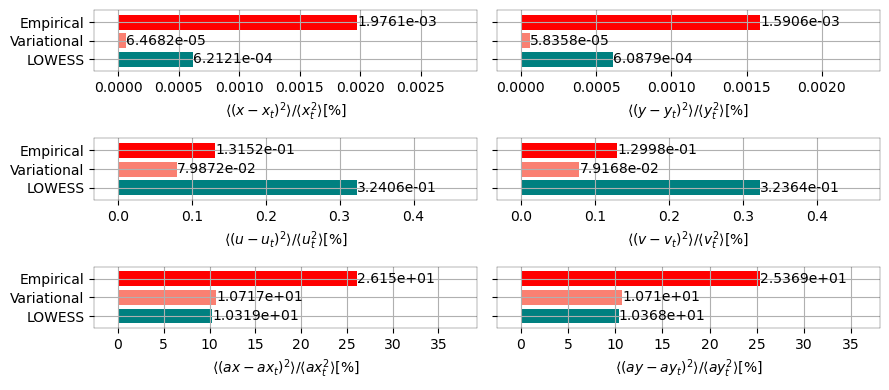

In [14]:
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(9, 4))
i = 0
axs = axs.flatten()
for var in [
    "x",
    "y",
    "u",
    "v",
    "ax",
    "ay",
]:
    ax = axs[i]
    dfr[var].plot.barh(ax=ax, color=["teal", "salmon", "r"], width=0.8)
    ax.grid()
    ax.set_xlim(-0.1 * dfr[var].max(), dfr[var].max() * 1.5)
    i += 1
    ax.set_xlabel(
        rf"$\langle ({var}-{var}_t)^2 \rangle / \langle {var}_t^2 \rangle [\%]$"
    )
    ax.bar_label(
        ax.containers[0],
        labels=[
            np.format_float_scientific(l, precision=4, exp_digits=2)
            for l in dfr[var].values
        ],
    )
fig.tight_layout()
# fig.suptitle('refcase =' +str(ref_case) + '\n spydell ' +str(parameters_spydell)+'\n variational '+str(parameters_var)+'\n lowess '+str(parameters_lowess),
#            x= 0.5, y=-0.02, fontsize=8)
path = os.path.join(images_dir, "comp_method_ref_case.png")
fig.savefig(path, dpi=250)